# Word2Vec
Word2Vec uses NCE loss function, but it is not yet included in PyTorch. So we will just use softmax. 

In [14]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
word_pair = [['cat', 'white'],
             ['cat', 'animal'],
             ['flower', 'white'],
             ['flower', 'plant'],
             ['cactus', 'green'],
             ['cactus', 'plant'],
             ['dog', 'black'],
             ['dog', 'animal'],
             ['elephant', 'gray'],
             ['elephant', 'animal'],
             ['rose', 'red'],
             ['rose', 'plant'],
             ['car', 'red'],
             ['dish', 'red'],
             ['jasmine', 'plant'],
             ['jasmine', 'white']]


word_list = set(np.array(word_pair).flatten())
word_dict = {w: i for i, w in enumerate(word_list)}
skip_grams = [[word_dict[word[0]], word_dict[word[1]]] for word in word_pair]

In [22]:
label = th.LongTensor(skip_grams)[:, 0].contiguous()
context = th.LongTensor(skip_grams)[:, 1].contiguous()
skip_grams_dataset = data_utils.TensorDataset(label, context)
train_loader = th.utils.data.DataLoader(skip_grams_dataset, batch_size=8, shuffle=True)
test_loader = th.utils.data.DataLoader(skip_grams_dataset, batch_size=1, shuffle=False)

In [23]:
class Word2Vec(nn.Module) :
    def __init__(self):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(len(word_list), 2)
        self.linear = nn.Linear(2, len(word_list), bias=True)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.linear(x)
        return F.log_softmax(x)
    
model = Word2Vec()
loss_fn = nn.NLLLoss() 
optimizer = th.optim.Adam(model.parameters(), lr=0.1)

In [24]:
model.train()
for epoch in range(100):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target) #(입력 생성)
        output = model(data) # model 생성
        loss = F.nll_loss(output, target) #loss 생성
        optimizer.zero_grad() # zeroGrad
        loss.backward() # calc backward gradients
        optimizer.step() # update parameters

In [25]:
model.eval()

invDic = { i : w for w, i in word_dict.items()}
print('Input : true : pred')

for x, y in test_loader :
    x, y = Variable(x.squeeze()), y.squeeze()
    y_pred = model(x).max(1)[1].data[0][0]
    print('{:s} : {:s} : {:s}'.format(invDic[x.data[0]], invDic[y[0]], invDic[y_pred]))

Input : true : pred
cat : white : animal
cat : animal : animal
flower : white : plant
flower : plant : plant
cactus : green : plant
cactus : plant : plant
dog : black : animal
dog : animal : animal
elephant : gray : animal
elephant : animal : animal
rose : red : red
rose : plant : red
car : red : red
dish : red : red
jasmine : plant : plant
jasmine : white : plant


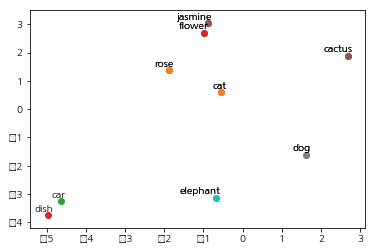

In [26]:
for i in label :
    x = Variable(th.LongTensor([i]))
    fx, fy = model.embedding(x).squeeze().data
    plt.scatter(fx, fy)
    plt.annotate(invDic[i], xy=(fx, fy), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')